In [1]:
# Fix root path
import sys
sys.path.append('..')

In [2]:
import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from art.attacks.evasion import BasicIterativeMethod, FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from defences.region_based_classifier import RegionBasedClassifier
from defences.util import dataset2tensor, get_correct_examples, merge_and_generate_labels, get_roc
from defences.baard import ApplicabilityStage, ReliabilityStage, DecidabilityStage, BAARDOperator, flatten

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cuda
CPU threads: 24


In [5]:
PATH_DATA = os.path.join('..', 'data')
PATH_RESULTS = os.path.join('..', 'results', 'mnist_base_model.pt')
BATCH_SIZE = 128
EPOCHS = 20
N_ADV = 2000

In [6]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.MNIST(PATH_DATA, train=True, download=True, transform=transforms)
dataset_test = datasets.MNIST(PATH_DATA, train=False, download=True, transform=transforms)

# From PyTorch dataset to Numpy array
tensor_X_train, tensor_y_train = dataset2tensor(dataset_train)
X_train = tensor_X_train.cpu().detach().numpy()
y_train = tensor_y_train.cpu().detach().numpy()
tensor_X_test, tensor_y_test = dataset2tensor(dataset_test)
X_test = tensor_X_test.cpu().detach().numpy()
y_test = tensor_y_test.cpu().detach().numpy()

# Split model training set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=5000)
dataset_train = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long))

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Check sizes
print(X_train.shape, X_val.shape, X_test.shape)

(55000, 1, 28, 28) (5000, 1, 28, 28) (10000, 1, 28, 28)


## Train point-based classifier

In [8]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(9216, 200)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(200, 10)
        self.softmax = nn.Softmax(dim=1)

    def before_softmax(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.before_softmax(x)
        x = self.softmax(x)
        return x

In [9]:
# Create Neural Network model
model = BaseModel()
model.to(device)
print('Number of layers: {}'.format(len(list(model.children()))))

Number of layers: 10


In [10]:
def train(model, loader, loss, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        outputs = model(x)
        l = loss(outputs, y)
        l.backward()
        optimizer.step()

        # for display
        total_loss += l.item() * batch_size
        preds = outputs.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [11]:
def validate(model, loader, loss, device=device):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            outputs = model(x)
            l = loss(outputs, y)
            total_loss += l.item() * batch_size
            preds = outputs.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [12]:
def predict(model, X, batch_size=BATCH_SIZE, device=device):
    model.eval()
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    tensor_pred = -torch.ones(len(X), dtype=torch.long)
    
    start = 0
    with torch.no_grad():
        for x in loader:
            x = x[0].to(device)
            n = x.size(0)
            end = start + n
            outputs = model(x)
            tensor_pred[start:end] = outputs.max(1)[1].type(torch.long)
            start += n

    return tensor_pred

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss=nn.CrossEntropyLoss()

In [14]:
since = time.time()
for epoch in range(EPOCHS):
    start = time.time()
    tr_loss, tr_acc = train(model, dataloader_train, loss, optimizer)
    va_loss, va_acc = validate(model, dataloader_test, loss)
    
    time_elapsed = time.time() - start
    print(('{:2d}/{:d}[{:s}] Train Loss: {:.4f} Acc: {:.4f}%, ' +
        'Test Loss: {:.4f} Acc: {:.4f}%').format(
            epoch+1, EPOCHS, str(datetime.timedelta(seconds=time_elapsed)),
            tr_loss, tr_acc*100.,
            va_loss, va_acc*100.))
    
time_elapsed = time.time() - since
print('Total run time: {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

# if not os.path.exists('results'):
#     os.makedirs('results')

# torch.save(model.state_dict(), PATH_RESULTS)

 1/20[0:00:02.182491] Train Loss: 1.8794 Acc: 63.7291%, Test Loss: 1.6462 Acc: 81.7000%
 2/20[0:00:02.152731] Train Loss: 1.6118 Acc: 85.1382%, Test Loss: 1.5468 Acc: 91.6500%
 3/20[0:00:02.137407] Train Loss: 1.5418 Acc: 92.3073%, Test Loss: 1.5304 Acc: 93.2600%
 4/20[0:00:02.160982] Train Loss: 1.5244 Acc: 93.9164%, Test Loss: 1.5228 Acc: 94.1000%
 5/20[0:00:02.145597] Train Loss: 1.5146 Acc: 94.8364%, Test Loss: 1.5073 Acc: 95.6600%
 6/20[0:00:02.139364] Train Loss: 1.5059 Acc: 95.6873%, Test Loss: 1.5013 Acc: 96.0300%
 7/20[0:00:02.114150] Train Loss: 1.5026 Acc: 95.9473%, Test Loss: 1.5008 Acc: 96.0700%
 8/20[0:00:02.122438] Train Loss: 1.4994 Acc: 96.3182%, Test Loss: 1.5007 Acc: 96.1200%
 9/20[0:00:02.127906] Train Loss: 1.4967 Acc: 96.5073%, Test Loss: 1.4946 Acc: 96.8200%
10/20[0:00:02.128530] Train Loss: 1.4947 Acc: 96.7291%, Test Loss: 1.4978 Acc: 96.5200%
11/20[0:00:02.132614] Train Loss: 1.4928 Acc: 96.8982%, Test Loss: 1.4916 Acc: 97.0100%
12/20[0:00:02.131196] Train Loss

In [15]:
# Load model from saved file
# model.load_state_dict(torch.load(PATH_RESULTS))

# _, acc_test = validate(model, dataloader_test, loss)
# print('Test set accuracy: {:.4f}'.format(acc_test*100))

## Remove missclassified samples

In [16]:
print('Training set: {}'.format(len(dataset_train)))
tensor_train_X, tensor_train_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
dataset_train_perfect = TensorDataset(tensor_train_X, tensor_train_y)
dataloader_train_perfect = DataLoader(dataset_train_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_train_perfect, loss)
print('Accuracy on {} filtered training examples: {:.4f}%'.format(len(dataloader_train_perfect.dataset), acc*100))

print('Test set: {}'.format(len(dataset_test)))
tensor_test_X, tensor_test_y = get_correct_examples(model, dataset_test, device=device, return_tensor=True)
dataset_test_perfect = TensorDataset(tensor_test_X, tensor_test_y)
dataloader_test_perfect = DataLoader(dataset_test_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_test_perfect, loss)
print('Accuracy on {} filtered test examples: {:.4f}%'.format(len(dataloader_test_perfect.dataset), acc*100))

Training set: 55000
Accuracy on 53953 filtered training examples: 100.0000%
Test set: 10000
Accuracy on 9749 filtered test examples: 100.0000%


## Create adversarial examples 

In [17]:
classifier = PyTorchClassifier(
    model=model, 
    loss=loss, 
    input_shape=(1, 28, 28), 
    optimizer=optimizer,
    nb_classes=10,
    clip_values=(0.0, 1.0),
    device_type=device
)

# attack = FastGradientMethod(estimator=classifier, eps=0.2)
attack = BasicIterativeMethod(estimator=classifier, eps=0.2)

In [18]:
# Prepare dataset for adversarial examples
n = len(dataset_test_perfect)
indices = torch.randperm(n)[:N_ADV]

pt_subset_X = tensor_test_X[indices]  # PyTorch Tensor
pt_subset_y = tensor_test_y[indices]

subset_X = pt_subset_X.cpu().detach().numpy()
subset_y = pt_subset_y.cpu().detach().numpy()

In [19]:
# Create adversarial examples
subset_pred = np.argmax(classifier.predict(subset_X), axis=1)
accuracy = np.sum(subset_pred == subset_y) / float(len(subset_pred))
print("Model accuracy on clean examples: {:.4f}%".format(accuracy * 100))

# Generate adversarial examples
subset_adv = attack.generate(x=subset_X)
subset_pred = np.argmax(classifier.predict(subset_adv), axis=1)

accuracy = np.sum(subset_pred == subset_y) / float(len(subset_pred))
print("Model accuracy on adversarial examples: {:.4f}%".format(accuracy * 100))

PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]Model accuracy on clean examples: 100.0000%
Model accuracy on adversarial examples: 5.9500%


## BAARD

## Applicability Stage

In [20]:
# Use the 2nd half 1000 samples for validation
X_val, labels_val = merge_and_generate_labels(subset_adv[1000:], subset_X[1000:])
pred_val = np.concatenate((subset_pred[1000:], subset_y[1000:]))

X_test_2, labels_test_2 = merge_and_generate_labels(subset_adv[:1000], subset_X[:1000])
pred_test_2 = np.concatenate((subset_pred[:1000], subset_y[:1000]))

### Testing MNIST

In [21]:
stage1 = ApplicabilityStage(quantile=0.9999)
stage1.fit(X_train, y_train)
len(np.where(stage1.predict(X_train, y_train))[0]) / len(X_train)

0.016236363636363636

In [22]:
# Validation set
print(X_val.shape, pred_val.shape)
len(np.where(stage1.predict(X_val, pred_val))[0]) / len(X_val)

(2000, 784) (2000,)


0.5125

In [23]:
len(np.where(stage1.predict(subset_X, subset_y))[0]) / len(subset_X)

0.0225

In [24]:
len(np.where(stage1.predict(subset_adv, subset_pred))[0]) / len(subset_adv)

1.0

In [25]:
X_mix, labels_adv_mix = merge_and_generate_labels(subset_adv, subset_X)
pred_mix = np.concatenate((subset_pred, subset_y))

In [26]:
len(np.where(stage1.predict(X_mix, pred_mix))[0]) / len(X_mix)

0.51125

## Reliability Stage

In [28]:
k = 10
stage2 = ReliabilityStage(n_classes=10, k=k)

In [29]:
stage2.fit(X_train, y_train)

In [30]:
stage2.search_thresholds(X_val, pred_val, labels_val)

In [31]:
pred = stage2.predict(X_test_2, pred_test_2)
print(pred[:5], pred[-5:])

[1 0 0 0 1] [0 0 0 0 0]


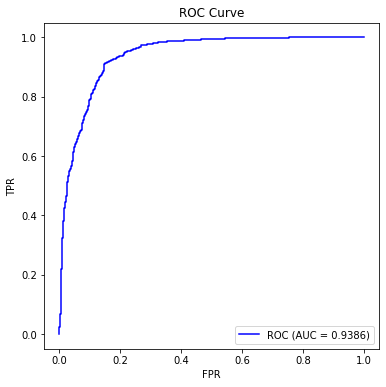

In [33]:
# On validation set
probs = stage2.predict_proba(X_val, pred_val)
_, _, auc_score, _ = get_roc(labels_val, probs[:, 1], show_plot=True)

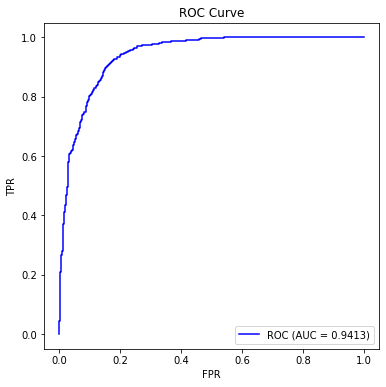

In [34]:
# On test set
probs = stage2.predict_proba(X_test_2, pred_test_2)
_, _, auc_score, _ = get_roc(labels_test_2, probs[:, 1], show_plot=True)

## Testing Decidability Stage

In [35]:
# X_tain, y_train
# X_val, pred_val, labels_val
# X_test_2, pred_test_2, labels_test_2

In [36]:
k = 100
stage3 = DecidabilityStage(n_classes=10, k=k, n_bins=5)

In [37]:
stage3.fit(X_train, y_train)

In [38]:
stage3.search_thresholds(X_val, pred_val, labels_val)

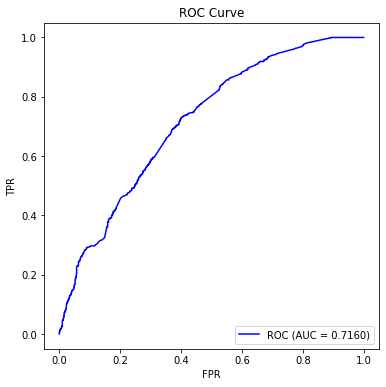

In [40]:
# On test set
probs = stage3.predict_proba(X_test_2, pred_test_2)
_, _, auc_score, _ = get_roc(labels_test_2, probs[:, 1], show_plot=True)

## Testing BAARD Operator

In [41]:
stages = []
stages.append(ApplicabilityStage(n_classes=10, quantile=0.999))
stages.append(ReliabilityStage(n_classes=10, k=10))
stages.append(DecidabilityStage(n_classes=10, k=100, n_bins=5))

baard = BAARDOperator(stages=stages)

In [42]:
print(X_train.shape, y_train.shape)

(55000, 1, 28, 28) (55000,)


In [43]:
baard.fit(X_train, y_train)

In [44]:
print(X_val.shape, pred_val.shape, labels_val.shape)

(2000, 784) (2000,) (2000,)


In [45]:
# We already filter the misclassified samples. 
# 1st 1000 samples are adversarial examples, 2nd half are benign samples.
pred = np.argmax(classifier.predict(X_val.reshape(2000,1,28,28)), axis=1)
print(np.all(pred == pred_val))

True


In [46]:
baard.search_thresholds(X_val, pred_val, labels_val)

In [47]:
y_test_2 = np.concatenate((subset_y[:1000], subset_y[:1000]))

print(np.all(y_test_2[:1000] == pred_test_2[:1000]))
print(np.all(y_test_2[1000:] == pred_test_2[1000:]))
print(np.all(labels_test_2 == labels_val))
pred = np.argmax(classifier.predict(X_test_2.reshape(2000,1,28,28)), axis=1)
print(np.all(pred == pred_test_2))

print(X_test_2.shape, y_test_2.shape, pred_test_2.shape, labels_test_2.shape)

False
True
True
True
(2000, 784) (2000,) (2000,) (2000,)


In [48]:
results = baard.detect(X_test_2, pred_test_2)
# Should be 1000 samples
print(np.sum(results))

1436


In [49]:
print(np.sum(results[:1000]), np.sum(results[1000:]))

1000 436
